# Assignment 3: Predictive analysis - Part 1: Linear Regression
## Group 105
- Natasa Bolic (300241734)
- Brent Palmer (300193610)
## Imports

In [75]:
# imports
import pandas as pd
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import mean_squared_error

## Introduction

This notebook is for part 1 of Assignment 3, where we perform an empirical study using linear regression. We have chosen to conduct the empirical study on the `Vehicle Dataset` from Kaggle, which contains 4340 observations describing used cars that were being sold on an online platform for used car sales, called CarDehko. Thus, our goal is to predict the selling price of used cars using linear regression based on the features in the dataset.

We begin by describing the dataset and performing an initial exploration to provide context on the data we are working with. Then, we clean the data using the validity checks from Assignment 2. Please run these cells in order, as each check builds on the previous one to make sure that the dataset is progressively validated and cleaned as errors are encountered. If a validity check from Assignment 2 does not apply to our dataset, we provide a brief explanation as to why we have chosen to exclude it. Next, we perform categorical feature encoding to transform all the relevant categorical features into one-hot encoded numerical features such that they can be used in the linear regression model. Next, we split the data into training and testing sets, since we only want to apply outlier detection and feature engineering to the training set (as the test set should remain "unseen"). Then, we perform outlier detection and deletion with the goal of improving the model performance (which we check in a later step). This is followed by an exploration of the `LinearRegression` method in `scikit-learn` which will be used in a subsequent step. Next, we perform feature engineering to attempt to enrich our analysis (on both the original training set and the training set with outliers removed). Finally, we compare the performance of the following four models that we constructed using cross validation on the training set:
- Default model (no outlier removal nor feature engineering),
- Model with outlier removal (no feature engineering),
- Model with feature engineering (no outlier removal),
- Model with outlier removal and feature engineering.

Upon choosing the model that has the best validation performance, we apply it to the test set and analyze the results.



## Dataset Description

**Url:** https://www.kaggle.com/datasets/nehalbirla/vehicle-dataset-from-cardekho <br>
**Name:** Vehicle Dataset <br>
**Author:** The author is not provided. However, the data is scraped from CarDekho, which is an online platform for selling and buying used cars in India. <br>
**Purpose:** The dataset consists of features of used cars. One purpose of the dataset is to allow users to practice linear regression to predict car prices, as described on Kaggle. However, it does not appear that the dataset has one original purpose, it can be used for many car-related applications. <br>
**Shape:** There are 4340 rows and 8 columns. (4340, 8)<br>
**Features:**
- `name` (categorical): The name of the car, including the car brand and the model name and variants.
- `year` (numerical): The year that the car was manufactured.
- `selling_price` (numerical): The price of the car.
- `km_driven` (numerical): The number of kilometres that the car has been driven.
- `fuel` (categorical): The fuel type of the car, which can be petrol, diesel, CNG, LPG or electric.
- `seller_type` (categorical): The type of the seller, which can be either an individual or a dealer.
- `transmission` (categorical): The car's gear transmission, which can be either automatic or manual.
- `owner` (categorical): The number of individuals that have previously owned the car.

Note: we have already used a dataset in the same domain (cars) in a previous assignment, but this is a different dataset with different features.

## Loading Data and Basic Exploration

In [76]:
# Read in the dataset from a public repository
url = "https://raw.githubusercontent.com/Natasa127/CSI4142-A3/refs/heads/main/Dekho-Car-Details.csv"
car_df = pd.read_csv(url)
car_df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner


In [77]:
car_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   name           4340 non-null   object
 1   year           4340 non-null   int64 
 2   selling_price  4340 non-null   int64 
 3   km_driven      4340 non-null   int64 
 4   fuel           4340 non-null   object
 5   seller_type    4340 non-null   object
 6   transmission   4340 non-null   object
 7   owner          4340 non-null   object
dtypes: int64(3), object(5)
memory usage: 271.4+ KB


In [78]:
car_df.shape

(4340, 8)

## Regression Empirical Study

### (a) Cleaning the data

In this section, we will use the validity checks from `Assignment 2` to identify any invalid data. If needed, an imputation method may be used to clean the data. Note that we will be doing each of the ten validity checks, although they might be in a different order than in assignment 2. They will be clearly enumerated. Furthermore, in `Assignment 2`, we saved a copy of the invalid rows in our validity checks. In this assignment, we will first check the count of invalid rows; if there are none, we will omit the code that saves a copy, and displays invalid rows. If we find the error count to be non-zero, we will then clean it instead in addition to displaying some of the invalid values.

#### Validity Check 1: Exact Duplicates

We first check for exact duplicates in the car dataset. This check verifies whether there are rows that are identical over all columns.

**References:** <br>
Exact Duplicates: https://uottawa.brightspace.com/d2l/le/content/490358/viewContent/6620388/View (Slide 27)

In [79]:
# Exact duplicates check

# Apply the .duplicated method to the DataFrame to create a Series, with exact duplicates set to True
duplicates = car_df.duplicated()

# Print the number of rows that are exact duplicates
print(f"Number of duplicate rows: {duplicates.sum()}")

Number of duplicate rows: 763


There are 763 exact duplicate rows, so we look into the actual rows to determine how to handle them.

In [80]:
# Save the invalid rows
invalid_exact_duplicate_df = car_df.loc[duplicates]

# Display the first 3 rows that are exact duplicates
print("Examples of three exact duplicate rows:")
invalid_exact_duplicate_df.head(3)

Examples of three exact duplicate rows:


,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
13,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
14,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
15,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner


It makes sense that the rows have some attributes in common, such as cars with the same name having the same transmission. However, it is unlikely that two cars have exactly the same attributes, particularly due to the attribute `km_driven`, which depends greatly on the owners of the car (an attribute which is not recorded).

A common tactic for sellers on online market platforms, like CarDekho, is to relist their product so that their listing appears newer and higher up in the page. So, we believe that these duplicates are likely due to multiple listings of the same cars. Since it is likely that the duplicated entries represent the same car, we believe it is justified to keep one of the duplicates and remove the rest. In other words, we handle the exact duplicates using listwise removal.

In addition, we note that the number of entries deleted does not make up a very large proportion of the data, so we can delete the instances without worrying about compromising the quality of the rest of our analysis (there are still 3577 instances).

In [81]:
# Select the all the entries that were not duplicated, and the first instance of every duplicated entry
cleaned_car_df = car_df.loc[~duplicates]
# Print the number of valid entries remaining
print(f"Number of rows after removing duplicates: {len(cleaned_car_df)}")

Number of rows after removing duplicates: 3577


#### Validity Check 2: Format errors

None of the features in this dataset have a specific format to be verified, so the format check does not apply here. Note that we could check that `year` is in the correct format, but since it is stored as an `integer` (and not a `datetime` object), we decide to check its validity through the datatype and range checks instead.

#### Validity Check 3: Uniqueness errors

None of the features in this dataset are intended to be unique, so the uniqueness check does not apply here.

#### Validity Check 4: Presence errors

We will use the presence check from `Assignment 2` to verify whether there is missing data in any of the columns. Minimal changes are necessary to the code; instead of taking a parameter input, we will simply iterate over all of the columns to determine if any of them have missing values. We also added a check for strings of whitespace, which we qualify as a missing value as well.

In [82]:
# Presence check

# Iterate over each column and perform the presence check on each
for column in cleaned_car_df:
    # Apply pd.isna() to the test attribute, or check if it is a string of whitespace, setting rows with missing values in the designated column to True
    invalid_presence = cleaned_car_df[column].apply(lambda attribute: (pd.isna(attribute) or (isinstance(attribute, str) and attribute.strip() == "")))

    # Print the number of rows with a missing value in the chosen test attribute
    print(f"Number of rows where the {column} value is missing: {invalid_presence.sum()}")

Number of rows where the name value is missing: 0
Number of rows where the year value is missing: 0
Number of rows where the selling_price value is missing: 0
Number of rows where the km_driven value is missing: 0
Number of rows where the fuel value is missing: 0
Number of rows where the seller_type value is missing: 0
Number of rows where the transmission value is missing: 0
Number of rows where the owner value is missing: 0


Since there are no missing values in any of the columns, no cleaning is required.

#### Validity Check 5: Length errors

None of the features in this dataset are intended to be a specific length, so the length check does not apply here.

#### Validity Check 6: Look-up errors

We will use the look-up check from `Assignment 2` to validate that the column values exist in a pre-defined finite set of values, if applicable. Minimal changes are necessary to the code from the previous assignment; we define a dictionary containing all of the relevant features along with their look-up tables. Then, we iterate over all of these features and apply the procedure from the previous assignment.

**References:**<br>
Boolean indexing: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#boolean-indexing

In [83]:
# Validity check

# Dictionary containing every feature's look-up table of valid values
look_up_dict = {
    "fuel": ["Petrol", "Diesel", "CNG", "LPG", "Electric"],
    "seller_type": ["Individual", "Dealer"],
    "transmission": ["Automatic", "Manual"],
    "owner": ["First Owner", "Second Owner", "Third Owner", "Fourth & Above Owner", "Test Drive Car"]
}

# Checks if a single value is in the look-up table
def look_up_filter(value, look_up_table):
    return value in look_up_table

# Apply the function to every feature, setting rows whose value is not in the look-up table to True
for feature in look_up_dict.keys():
    invalid_look_up = cleaned_car_df[feature].apply(
        lambda attribute: not look_up_filter(attribute, look_up_dict[feature])
    )
    # Print the number of rows with a value that is not in the look-up table for the designated attribute
    print(f"Number of rows where the {feature} value is not in the look-up table: {invalid_look_up.sum()}")


Number of rows where the fuel value is not in the look-up table: 0
Number of rows where the seller_type value is not in the look-up table: 33
Number of rows where the transmission value is not in the look-up table: 0
Number of rows where the owner value is not in the look-up table: 0


There are values that are not in the look-up table in the `seller_type` feature. We will investigate this further by determining what the invalid values are.

In [84]:
# Apply the check once again for `seller_type`
feature = "seller_type"
invalid_look_up = cleaned_car_df[feature].apply(
    lambda attribute: not look_up_filter(attribute, look_up_dict[feature])
)

# Save the invalid rows
invalid_look_up_df = cleaned_car_df.loc[invalid_look_up]

# Determine what the invalid values are
print(invalid_look_up_df[feature].unique())

['Trustmark Dealer']


All of the invalid entries for `seller_type` have the value 'Trustmark Dealer'. Since the `seller_type` attribute is intended to indicate whether the seller is a dealer or an individual, we believe it is reasonable to impute the invalid values with 'Dealer' since a trustmark dealer is a type of dealer. We do this imputation below using boolean indexing.

In [85]:
cleaned_car_df.loc[invalid_look_up, 'seller_type'] = 'Dealer'

#### Validity Check 7: Consistency errors

We believe that there are no relationships that need to be checked for consistency in the dataset. We could verify that cars with more kilometers driven have a lower price than cars with less kilometers driven, but this is not a strict rule. For example, the price should also depend on the maintenance of the car, which is not recorded. Additionally, the price should depend on many more factors such as the brand of the car. So, we do not believe that there exist strict rules that can be implemented in this case.

#### Validitity Check 8: Data type errors

We will use the data type check from `Assignment 2`, specifically method 1 which checks if the data in a column is stored in the correct datatype, to validate that the data is properly stored and of the correct datatype. Minimal changes are necessary to the code; we define a dictionary mapping each feature to its correct datatype. Then, we iterate over all of these features and apply method 1 from the previous assignment.

In [86]:
# Data type check

# Evalutes a single value's data type against the desired data type
def type_filter_method1(value, test_datatype):
    if pd.isna(value):
        return False
    return isinstance(value, test_datatype)

# Create a dictionary that maps each attribute to its correct datatype
data_type_dict = {
    "name": str,
    "year": int,
    "selling_price": int,
    "km_driven": int,
    "fuel": str,
    "seller_type": str,
    "transmission": str,
    "owner": str
}

# Apply the function to every feature, setting rows whose value is not stored as the correct datatype to True
for feature in data_type_dict.keys():
    invalid_datatype = cleaned_car_df[feature].apply(
        lambda attribute: not type_filter_method1(attribute, data_type_dict[feature])
    )
    # Print the number of rows with a value that is not stored as the correct datatype for the designated attribute
    print(f"Number of rows where the {feature} value is not stored as the correct datatype ({data_type_dict[feature]}): {invalid_datatype.sum()}")

Number of rows where the name value is not stored as the correct datatype (<class 'str'>): 0
Number of rows where the year value is not stored as the correct datatype (<class 'int'>): 0
Number of rows where the selling_price value is not stored as the correct datatype (<class 'int'>): 0
Number of rows where the km_driven value is not stored as the correct datatype (<class 'int'>): 0
Number of rows where the fuel value is not stored as the correct datatype (<class 'str'>): 0
Number of rows where the seller_type value is not stored as the correct datatype (<class 'str'>): 0
Number of rows where the transmission value is not stored as the correct datatype (<class 'str'>): 0
Number of rows where the owner value is not stored as the correct datatype (<class 'str'>): 0


Since there are no values stored as the incorrect datatype in any of the columns, no cleaning is required.

#### Validitity Check 9: Range errors

We will use the range check from `Assignment 2` to validate that the numerical data is in the correct range. Minimal changes are necessary to the code; we define a dictionary mapping each feature to its correct range. Then, we iterate over all of these features and apply the procedure from the previous assignment.

We consider a reasonable range of possible years for cars on the market to be 1950 to the present. Since the selling price and number of kilometers driven cannot be negative, we set a minimum of 0. Based on an article about expensive car models in India, we find that a reasonable upper bound for possible prices is roughly 122500000 Rupees. Additionally, we choose a large number for the maximum number of kilometers driven.

**References:**<br>
Most expensive cars in India: https://northfleet.in/expensive-car-models/

In [87]:
# Create a dictionary that maps each numerical attribute to its acceptable range in the format [min, max]
range_dict = {
    "year": [1950, 2025],
    "selling_price": [0, 122500000],
    "km_driven": [0, 5000000]
}

# Evaluates a single value against a given range
def range_filter(value, minimum, maximum):
    try:
        value = float(value)
    except Exception as e:
        return False
    return minimum <= value <= maximum

# Apply the function to every feature in the dictionary, setting out of range values to True
for feature in range_dict.keys():
    invalid_range = cleaned_car_df[feature].apply(
        lambda attribute: not range_filter(attribute, range_dict[feature][0], range_dict[feature][1])
    )
    # Print the number of rows with a value that is not stored as the correct datatype for the designated attribute
    print(f"Number of rows where the {feature} value is not in the correct range {range_dict[feature]}: {invalid_range.sum()}")

Number of rows where the year value is not in the correct range [1950, 2025]: 0
Number of rows where the selling_price value is not in the correct range [0, 122500000]: 0
Number of rows where the km_driven value is not in the correct range [0, 5000000]: 0


Since there are no values outside of the correct range, no cleaning is required.

#### Validity Check 10: Near Duplicate Errors

Our near duplicate check finds rows that differ only by a synonym in a designated attribute. There are no attributes in our dataset with synonyms for a term, which we check by observing the unique values in every categorical variable. Note that we do not check for the `name` attribute since there are over 1400 unique values, and we do not consider it as a predictor in the analysis (which is justified in the Categorical feature encoding section).

In [88]:
# Print the number of unique car names
print(cleaned_car_df['name'].nunique())

1491


In [89]:
# Print the unique values of the categorical features
print(cleaned_car_df['fuel'].unique())
print(cleaned_car_df['seller_type'].unique())
print(cleaned_car_df['transmission'].unique())
print(cleaned_car_df['owner'].unique())

['Petrol' 'Diesel' 'CNG' 'LPG' 'Electric']
['Individual' 'Dealer']
['Manual' 'Automatic']
['First Owner' 'Second Owner' 'Fourth & Above Owner' 'Third Owner'
 'Test Drive Car']


So, this check does not apply.

### (b) Categorical feature encoding

There are 5 five categorical features in this dataset: `name`, `fuel`, `seller_type`, `transmission` and `owner`. 

Since there are 1491 unique car names, we do not encode this feature, as it would produce 1491 additional columns. Moreover, since there are so many unique values, we do not believe that this feature would provide a lot of insight to the analysis. Thus, since it cannot be used in the linear regression model as a categorical feature, we drop it. We encode the rest of the categorical variables below using one-hot encoding.

An assumption of linear regression models is that the predictors are not correlated with each other, so when one-hot encoding a feature, we set `drop_first = True` to drop one of the encoded columns (corresponding to one of the categories) to avoid perfectly collinear features.

**References:**<br>
One-hot encoding: https://www.geeksforgeeks.org/ml-one-hot-encoding/ <br>
Linear regression assumptions: https://uottawa.brightspace.com/d2l/le/content/490358/viewContent/6661104/View (Slide 21)<br>
Drop a column: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html

In [90]:
# Apply one-hot encoding
car_df_encoded = pd.get_dummies(cleaned_car_df, columns=['fuel', 'seller_type', 'transmission', 'owner'], drop_first = True)
# Drop the `name` feature
car_df_encoded = car_df_encoded.drop("name", axis = 1)
# Display the first 3 rows
car_df_encoded.head(3)

,year,selling_price,km_driven,fuel_Diesel,fuel_Electric,fuel_LPG,fuel_Petrol,seller_type_Individual,transmission_Manual,owner_Fourth & Above Owner,owner_Second Owner,owner_Test Drive Car,owner_Third Owner
0,2007,60000,70000,0,0,0,1,1,1,0,0,0,0
1,2007,135000,50000,0,0,0,1,1,1,0,0,0,0
2,2012,600000,100000,1,0,0,0,1,1,0,0,0,0


### (f) Empirical Study

We are only doing part a of the empirical study here, as it must precede the other sections of the assignment, as per the professor's announcement.

#### Test Train Set Split

Before moving on to the next step of the study, we must do the first step of part f, which involves splitting the data into a training set and a test set. This is important, as we do not want to remove outliers from or add features to the test set. We should only be modifying the training set. We will perform the split on the encoded DataFrame.

We split the data such that 20% is reserved as a test set and the remaining 80% is used as the training set. Note that we will use 4-fold cross validation on the training set in a later step, which will involve creating 4 validation sets from the training set that we define in this section. So, we do not separate a validation set in this step (as specified by the professor).

**References:**<br>
Train test split: https://www.statology.org/pandas-train-test/

In [91]:
# Split the data into the test set and the training set
train, test = train_test_split(car_df_encoded, test_size = 0.2, random_state = 23)

# Show that the DataFrame split properly
print(f"The number of rows in the training set is {len(train)}, which is {round(100*len(train)/len(car_df_encoded))}% of the data.")
print(f"The number of rows in the test set is {len(test)}, which is {round(100*len(test)/len(car_df_encoded))}% of the data.\n")

# Show some example rows of the training set
print(f"Example rows of the training set: ")
train.head(3)

The number of rows in the training set is 2861, which is 80% of the data.
The number of rows in the test set is 716, which is 20% of the data.

Example rows of the training set: 


,year,selling_price,km_driven,fuel_Diesel,fuel_Electric,fuel_LPG,fuel_Petrol,seller_type_Individual,transmission_Manual,owner_Fourth & Above Owner,owner_Second Owner,owner_Test Drive Car,owner_Third Owner
3960,2013,430000,88000,1,0,0,0,1,1,0,1,0,0
1982,2019,500000,15000,0,0,0,1,1,1,0,0,0,0
938,2010,290000,87620,1,0,0,0,0,0,0,0,0,0


### (c) EDA and Outlier detection

We begin by doing EDA to identify visual outliers in the data. More specifically, we create scatterplots between the numerical predictors and the target `selling_price` to see if any observations appear to be isolated/have extreme values compared to the rest of the distribution, which could cause them to have an disproportionate influence on the linear regression.

**References:**<br>
Scatterplot: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html <br>
LOF: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html <br>
Outlier detection with LOF: https://scikit-learn.org/stable/auto_examples/neighbors/plot_lof_outlier_detection.html <br>
Outlier detection with LOF: https://medium.com/@ilyurek/anomaly-detection-with-local-outlier-factor-lof-b1b82227c15e

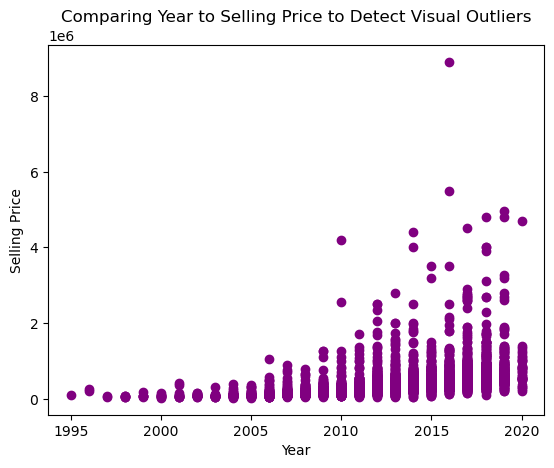

In [92]:
# Create the scatterplot of year compared to selling price
plt.scatter(train['year'], train['selling_price'], color="purple")

# Label the scatterplot
plt.xlabel("Year")
plt.ylabel("Selling Price")
plt.title("Comparing Year to Selling Price to Detect Visual Outliers")

plt.show()

Comparing the `year` to the `selling_price`, we observe that most observations follow the general pattern, but there are a few extreme values that deviate from the pattern.

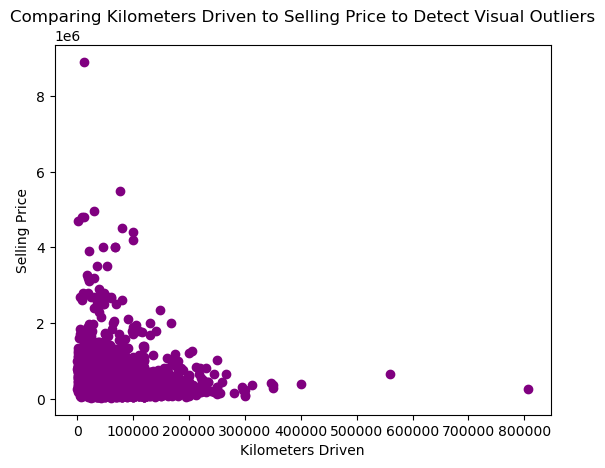

In [93]:
# Create the scatterplot of km driven compared to selling price
plt.scatter(train['km_driven'], train['selling_price'], color="purple")

# Label the scatterplot
plt.xlabel("Kilometers Driven")
plt.ylabel("Selling Price")
plt.title("Comparing Kilometers Driven to Selling Price to Detect Visual Outliers")

plt.show()

We observe several observations which appear to be outliers, since they are isolated from the rest of the observations. These are the observations where the `km_driven` is very high and the `selling_price` is very low, and the observations where the `km_driven` is very low and the `selling_price` is very high.

We note that there are appear to be more extreme outliers than in the previous case, so there is greater potential to skew the prediction of `selling_price`. So, we decide to apply LOF to `km_driven` and `selling_price` to further investigate the potential outliers.

According to the scikit-learn LOF outlier detection example, taking `n_neighbors = 20` works well in general, so we use the default of 20. The `contamination` parameter allows us to set the proportion of outliers in the dataset. Although we do not know the exact proportion of outliers in the dataset, a fairly small proportion of the data appeared to be outlying in the EDA section, so we set `contamination` to a low value of 0.01.

In [94]:
# Initialize the model
lof = LocalOutlierFactor(contamination = 0.01)
# Predict whether every value is an outlier or not using the model (-1 represents an outlier and +1 represents an inlier)
km_driven_pred = lof.fit_predict(train[['km_driven', 'selling_price']])
# Store the negative LOF scores (the higher, the more normal)
lof_score = lof.negative_outlier_factor_
# Store the outliers and inliers, and display a few outliers
inliers = train[km_driven_pred == 1].copy()
inliers['LOF_Score'] = lof_score[km_driven_pred == 1]
outliers = train[km_driven_pred == -1].copy()
outliers['LOF_Score'] = lof_score[km_driven_pred == -1]
outliers.head()

,year,selling_price,km_driven,fuel_Diesel,fuel_Electric,fuel_LPG,fuel_Petrol,seller_type_Individual,transmission_Manual,owner_Fourth & Above Owner,owner_Second Owner,owner_Test Drive Car,owner_Third Owner,LOF_Score
731,2018,4000000,68000,1,0,0,0,1,0,0,0,0,0,-1.994442
963,2020,4700000,1500,1,0,0,0,1,0,0,0,0,0,-2.241679
3981,2014,1030000,250000,1,0,0,0,1,1,0,1,0,0,-2.196022
3872,2016,8900000,13000,0,0,0,1,0,0,0,0,0,0,-6.083334
1705,2015,3500000,35000,1,0,0,0,1,0,0,0,0,0,-2.081089


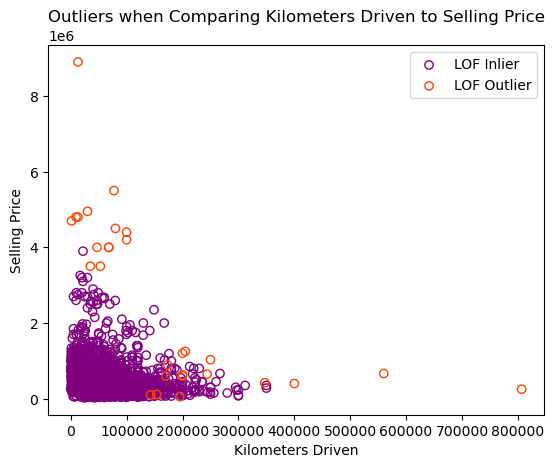

In [95]:
# Create the scatterplot of km driven compared to selling price for observations that were not detected as outliers in purple
plt.scatter(inliers['km_driven'], inliers['selling_price'], color="none", edgecolors="purple", label="LOF Inlier")
# Create the scatterplot of km driven compared to selling price for observations that were detected as outliers in orange
plt.scatter(outliers['km_driven'], outliers['selling_price'], color="none", edgecolors="orangered", label="LOF Outlier")

# Label the scatterplot
plt.xlabel("Kilometers Driven")
plt.ylabel("Selling Price")
plt.title("Outliers when Comparing Kilometers Driven to Selling Price")

# Add a legend
plt.legend()

plt.show()

We observe that LOF generally detected the isolated observations with extreme values as outliers. 

However, we believe that these observations may actually be novelties, as opposed to errors. Cars with very low mileage typically have less wear and tear, suggesting that they are in better condition, and a higher price may be justifiable. Similarly, cars with very high mileage are typically in worse condition, so a lower price may be justifiable. As such, it does not make sense to perform imputation to change the values of the novelties.

Thus, we remove them.

In [96]:
# Removing the outliers

# Create a copy of the training set with outliers removed
train_outliers_removed = train[km_driven_pred == 1].copy()
train_outliers_removed.head()

,year,selling_price,km_driven,fuel_Diesel,fuel_Electric,fuel_LPG,fuel_Petrol,seller_type_Individual,transmission_Manual,owner_Fourth & Above Owner,owner_Second Owner,owner_Test Drive Car,owner_Third Owner
3960,2013,430000,88000,1,0,0,0,1,1,0,1,0,0
1982,2019,500000,15000,0,0,0,1,1,1,0,0,0,0
938,2010,290000,87620,1,0,0,0,0,0,0,0,0,0
2039,2017,509999,44000,1,0,0,0,0,1,0,0,0,0
870,2013,450000,80000,1,0,0,0,1,1,0,0,0,0


### (d) Predictive analysis: Linear regression

We explore the `LinearRegression` method in scikit-learn. As expected, it minimizes the residual sum of squares between the predicted values and the actual values of the target in order to obtain the coefficients of a linear model. Note that all the default parameters are suitable for our situation. It has an attribute `coef_` which provides the estimated coefficients of the linear model. In order to fit the model, we must run `fit` on the instance of `LinearRegression`, and pass in the training data and the target values. We run `predict` on the instance of `LinearRegression` to obtain the predictions for our target feature.

**References:**<br>
Linear regression: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html <br>

### (e) Feature engineering

We construct two additional features.

The first is created using aggregation and ratios; we compute the ration between the number of kilometers driven by a car and the average number of kilometers driven by cars from that year. Our intuition behind this feature is that in recent years, people upgrade to new cars more frequently than in the past, so it is possible that older cars were designed to last greater wear and tear. So, an older car could have a higher number of kilometers driven but be in similar shape as a newer car with a lower number of kilometers driven, due to their design. Thus, we create a feature that compares a car's kilometers driven to the average number of kilometers driven in that year, where a value greater than 1 suggests that the car is in worse shape than average (has traversed more kilometers) and a value less than 1 suggests that the car is in better shape than average (has traversed less kilometers). Thus, this could provide context on the selling price of the car.

The second feature is created using time differences; we compute the average time the car was owned by each of its owners. If a car has been resold many times in a short span of time, it is possible that there is some defect or issue with the car that is causing people to pass it off, warranting a lower price. On the other hand, if the owners of the car have had it for a longer time, it is likely that the car was well-maintained to last that time, warranting a higher price. So, we believe this feature could be useful in the prediction. To calculate this value, we compute the difference between the year which the car is being sold (the present) and the year of the car to determine its age. Based on the Kaggle description of the dataset, the temporal coverage end date of the dataset is 06/26/2020, so we consider the "present" year to be 2020. Then, we divide the age by the number of owners the car has had. Note that if the car has had 4 owners or more, we divide by 4, as this is our best approximation to how many owners that car had. Also note that we count test drive cars as having one owner because they were owned only by the entity selling the car.

**References:**<br>
Grouping data: https://realpython.com/pandas-groupby/ <br>
Intuition behind how multiple ownerships can influence the quality of a used car: https://www.reddit.com/r/whatcarshouldIbuy/comments/1adzm4i/does_having_more_than_1_owner_hurt_the/

In [97]:
# Create a copy of the dataset to include the engineered features
train_feature_eng = train.copy()
# Create a Series indexed by the year containing the average km driven for that year
km_driven_by_year = train_feature_eng.groupby("year")["km_driven"].mean()
# Output the values for the most recent five years
km_driven_by_year.tail()

year
2016    57446.342342
2017    41977.967153
2018    28408.074380
2019    19941.947368
2020     8987.800000
Name: km_driven, dtype: float64

In [98]:
# Create a new feature which represents the ratio between the km driven and the mean km driven for cars from the same year
train_feature_eng['km_driven_ratio'] = train_feature_eng['km_driven'] / train_feature_eng['year'].apply(lambda x: km_driven_by_year.loc[x])
# Output a few sample rows
train_feature_eng[['year', 'km_driven', 'km_driven_ratio']].head()

,year,km_driven,km_driven_ratio
3960,2013,88000,1.168428
1982,2019,15000,0.752183
938,2010,87620,0.924955
2039,2017,44000,1.048169
870,2013,80000,1.062207


In [99]:
# Compute the age of the car
age = 2020 - train_feature_eng['year']
# Compute the number of owners of the car using the encoded columns
num_of_owners = 4*train_feature_eng['owner_Fourth & Above Owner'] + \
    3*train_feature_eng['owner_Third Owner'] + \
    2*train_feature_eng['owner_Second Owner'] + \
    1*train_feature_eng['owner_Test Drive Car'] + \
    1*(1-train_feature_eng['owner_Fourth & Above Owner']-train_feature_eng['owner_Third Owner']- \
       train_feature_eng['owner_Second Owner']-train_feature_eng['owner_Test Drive Car'])
# Create a new feature which represents the average duration in years that each owner has owned the car
train_feature_eng['duration_per_owner'] = age / num_of_owners
# Display some sample rows
train_feature_eng[['year', 'duration_per_owner', 'owner_Fourth & Above Owner', 'owner_Third Owner', 'owner_Second Owner', 'owner_Test Drive Car']].head()

,year,duration_per_owner,owner_Fourth & Above Owner,owner_Third Owner,owner_Second Owner,owner_Test Drive Car
3960,2013,3.5,0,0,1,0
1982,2019,1.0,0,0,0,0
938,2010,10.0,0,0,0,0
2039,2017,3.0,0,0,0,0
870,2013,7.0,0,0,0,0


In [100]:
# Repeat the process for the training set with outliers removed

# Create a copy of the dataset to include the engineered features on the training set with outliers removed
train_outliers_removed_feature_eng = train_outliers_removed.copy()
# Create a Series indexed by the year containing the average km driven for that year
km_driven_by_year_outliers_removed = train_outliers_removed_feature_eng.groupby("year")["km_driven"].mean()
# Create a new feature which represents the ratio between the km driven and the mean km driven for cars from the same year
train_outliers_removed_feature_eng['km_driven_ratio'] = train_outliers_removed_feature_eng['km_driven'] / \
                                        train_outliers_removed_feature_eng['year'].apply(lambda x: km_driven_by_year_outliers_removed.loc[x])


# Compute the age of the car
age = 2020 - train_outliers_removed_feature_eng['year']
# Compute the number of owners of the car using the encoded columns
num_of_owners = 4*train_outliers_removed_feature_eng['owner_Fourth & Above Owner'] + \
    3*train_outliers_removed_feature_eng['owner_Third Owner'] + \
    2*train_outliers_removed_feature_eng['owner_Second Owner'] + \
    1*train_outliers_removed_feature_eng['owner_Test Drive Car'] + \
    1*(1-train_outliers_removed_feature_eng['owner_Fourth & Above Owner']-train_outliers_removed_feature_eng['owner_Third Owner']-\
       train_outliers_removed_feature_eng['owner_Second Owner']-train_outliers_removed_feature_eng['owner_Test Drive Car'])
# Create a new feature which represents the average duration in years that each owner has owned the car
train_outliers_removed_feature_eng['duration_per_owner'] = age / num_of_owners

# Output a few sample rows
train_outliers_removed_feature_eng.head()

,year,selling_price,km_driven,fuel_Diesel,fuel_Electric,fuel_LPG,fuel_Petrol,seller_type_Individual,transmission_Manual,owner_Fourth & Above Owner,owner_Second Owner,owner_Test Drive Car,owner_Third Owner,km_driven_ratio,duration_per_owner
3960,2013,430000,88000,1,0,0,0,1,1,0,1,0,0,1.168428,3.5
1982,2019,500000,15000,0,0,0,1,1,1,0,0,0,0,0.753081,1.0
938,2010,290000,87620,1,0,0,0,0,0,0,0,0,0,0.937228,10.0
2039,2017,509999,44000,1,0,0,0,0,1,0,0,0,0,1.051658,3.0
870,2013,450000,80000,1,0,0,0,1,1,0,0,0,0,1.062207,7.0


### (f) Empirical study

We decide to use MSE and R-squared as our evaluation metrics, which are both commonly used evaluation metrics in the context of regression. R-squared indicates what proportion of the variation in `selling_price` can be explained by the model, i.e. by the variation of the predictors. So, we are aiming for a high value of R-squared. In other words, we want the R-squared value to be close to 1 since it ranges from 0 to 1. MSE quantifies how far our predictions are from the true values. It penalizes large errors more drastically due to the square. So, we are aiming for a low value of MSE (as close to 0 as possible). Note that `scikit-learn` uses negative MSE (`neg_mean_squared_error`), which is simply MSE multiplied by -1, so we multiply the scores we obtain by -1.

**References:**<br>
Linear regression: https://www.geeksforgeeks.org/python-linear-regression-using-sklearn/ <br>
Linear regression: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html <br>
Cross validation: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html <br>
Scoring with MSE: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter <br>
isin method: https://www.w3schools.com/python/pandas/ref_df_isin.asp <br>

In [101]:
def linear_regression(X_train, y_train):
    # Create the linear regression model
    reg = LinearRegression()

    # Train the model and calculate evaluation metrics using cross validation on the training set
    scoring_metrics = ['r2', 'neg_mean_squared_error']
    scores = cross_validate(reg, X_train, y_train, scoring=scoring_metrics, cv=4)

    # Print R^2 scores from the cross validation
    R_squared_scores = scores['test_r2']
    print("R^2 Scores:", R_squared_scores)
    print(f"Mean: {R_squared_scores.mean():.2f}")
    print(f"Standard deviation: {R_squared_scores.std():.2f}")

    # Print MSE scores from the cross validation
    MSE_scores = -1 * scores['test_neg_mean_squared_error']
    print("\nMSE Scores:", MSE_scores)
    print(f"Mean: {MSE_scores.mean():.2f}")
    print(f"Standard deviation: {MSE_scores.std():.2f}")

In [102]:
# Default method (no encoding, no feature engineering)

# Select all the features that will be used to train the model
X_train_default = train.loc[:, ~train.columns.isin(['selling_price'])]
# Select the target feature
y_train_default = train['selling_price']
# Run the linear regression
linear_regression(X_train_default, y_train_default)

R^2 Scores: [0.36653681 0.4548715  0.50614329 0.45015784]
Mean: 0.44
Standard deviation: 0.05

MSE Scores: [2.10600627e+11 1.42890369e+11 9.84487209e+10 1.26816709e+11]
Mean: 144689106523.53
Standard deviation: 41246696397.08


In [103]:
# Using outlier removal but not feature engineering

# Select all the features that will be used to train the model
X_train_outliers_removed = train_outliers_removed.loc[:, ~train_outliers_removed.columns.isin(['selling_price'])]
# Select the target feature
y_train_outliers_removed = train_outliers_removed['selling_price']
# Run the linear regression
linear_regression(X_train_outliers_removed, y_train_outliers_removed)

R^2 Scores: [0.48948618 0.50390834 0.51880079 0.49705248]
Mean: 0.50
Standard deviation: 0.01

MSE Scores: [6.79714791e+10 9.07072247e+10 8.76185302e+10 7.41434158e+10]
Mean: 80110162435.54
Standard deviation: 9375806842.68


In [104]:
# Using feature engineering but not outlier analysis

# Select all the features that will be used to train the model
X_train_feature_eng = train_feature_eng.loc[:, ~train_feature_eng.columns.isin(['selling_price'])]
# Select the target feature
y_train_feature_eng = train_feature_eng['selling_price']
# Run the linear regression
linear_regression(X_train_feature_eng, y_train_feature_eng)

R^2 Scores: [0.37265603 0.46296987 0.51957406 0.46037392]
Mean: 0.45
Standard deviation: 0.05

MSE Scores: [2.08566237e+11 1.40767604e+11 9.57713405e+10 1.24460452e+11]
Mean: 142391408221.25
Standard deviation: 41462919067.23


In [105]:
# Using feature engineering and outlier analysis

# Select all the features that will be used to train the model
X_train_outliers_removed_feature_eng = train_outliers_removed_feature_eng.loc[:, ~train_outliers_removed_feature_eng.columns.isin(['selling_price'])]
# Select the target feature
y_train_outliers_removed_feature_eng = train_outliers_removed_feature_eng['selling_price']
# Run the linear regression
linear_regression(X_train_outliers_removed_feature_eng, y_train_outliers_removed_feature_eng)

R^2 Scores: [0.50040628 0.51598274 0.5314902  0.50577683]
Mean: 0.51
Standard deviation: 0.01

MSE Scores: [6.65175408e+10 8.84994973e+10 8.53079944e+10 7.28572912e+10]
Mean: 78295580921.12
Standard deviation: 8966480313.22


The model using only outlier removal and the model using both outlier removal and feature engineering perform quite similarly, however, the model using both outlier removal and feature engineering has a slightly higher R-squared score and a slightly lower MSE. Thus, we select the fourth model (with both outlier removal and feature engineering) as the best system.

In order to apply the model to the test set, we must perform the feature engineering on the test set as well.

In [106]:
# Retrain the chosen model
final_reg = LinearRegression() 
final_reg.fit(X_train_default, y_train_default)

# Split the test set into the predictors (X_test) and the target variable (y_test)
X_test = test.loc[:, ~test.columns.isin(['selling_price'])]
y_test = test['selling_price']

# Perform predictions on the test set
y_test_pred = final_reg.predict(X_test)
# Output R^2 score and MSE on the test set
R_squared = final_reg.score(X_test, y_test)
MSE = mean_squared_error(y_true = y_test, y_pred = y_test_pred)
print("R-squared:", R_squared)
print("MSE:", MSE)

R-squared: 0.41794966198887895
MSE: 158051234681.15323


In [107]:
# Perform feature engineering on the test set

# Create a Series indexed by the year containing the average km driven for that year
km_driven_by_year_test = test.groupby("year")["km_driven"].mean()
# Create a new feature which represents the ratio between the km driven and the mean km driven for cars from the same year
test['km_driven_ratio'] = test['km_driven'] / test['year'].apply(lambda x: km_driven_by_year_test.loc[x])

# Compute the age of the car
age = 2020 - test['year']
# Compute the number of owners of the car using the encoded columns
num_of_owners = 4*test['owner_Fourth & Above Owner'] + \
    3*test['owner_Third Owner'] + \
    2*test['owner_Second Owner'] + \
    1*test['owner_Test Drive Car'] + \
    1*(1-test['owner_Fourth & Above Owner']-test['owner_Third Owner']- \
       test['owner_Second Owner']-test['owner_Test Drive Car'])
# Create a new feature which represents the average duration in years that each owner has owned the car
test['duration_per_owner'] = age / num_of_owners

Finally, we apply the chosen model to the test set to perform the final evaluation.

In [108]:
# Retrain the chosen model
final_reg = LinearRegression() 
final_reg.fit(X_train_outliers_removed_feature_eng, y_train_outliers_removed_feature_eng)

# Split the test set into the predictors (X_test) and the target variable (y_test)
X_test = test.loc[:, ~test.columns.isin(['selling_price'])]
y_test = test['selling_price']

# Perform predictions on the test set
y_test_pred = final_reg.predict(X_test)
# Output R^2 score and MSE on the test set
R_squared = final_reg.score(X_test, y_test)
MSE = mean_squared_error(y_true = y_test, y_pred = y_test_pred)
print("R-squared:", R_squared)
print("MSE:", MSE)

R-squared: 0.4107810530952929
MSE: 159997814577.40256


### (g) Results analysis

We begin with a table comparing the average cross validation R-squared and MSE scores for the four types of models. The best scores are highlighted with a star.

| Model Type  | R-squared Score | MSE Score |
|--------------|---------------|-----------|
| Default model (no outlier removal nor feature engineering)   |      0.44         |     1.44 x 10^11      |
| Model with outlier removal (no feature engineering)    |        0.50       |      8.01 x 10^10     |
| Model with feature engineering (no outlier removal)    |        0.45       |     1.42 x 10^11      |
| Model with outlier removal and feature engineering    |       0.51    ⭐    |     7.83 x 10^10  ⭐    |


The default model (with no outlier removal and no feature engineering) achieved an average cross validation R-squared score of 0.44 and MSE score of approximately 1.44 x 10^11. This means that only about 44% of the variation in the selling price can be explained by the predictors in the model, which is not ideal. The value of MSE is also very large, which is in part due to the large magnitude of the selling prices, but also due to errors in our predictions.

The model with outlier removal (with no feature engineering) achieved an average cross validation R-squared score of 0.50 and MSE score of approximately 8.01 x 10^10. So, about 50% of the variation in the selling price can be explained by the predictors in the model, which is not an extremely high proportion, but it is a fairly decent improvement (6% increase) from the default model. We believe that the difference in R-squared scores can be attributed to the outliers introducing greater variability that is harder to capture with the predictors. So, removing the outliers results in data that follows a more consistent pattern, making it easier for the model to learn the pattern using the predictors. Similarly, while the MSE score remains fairly large, it is noticeably lower than the default model, suggesting a good improvement. We believe that the difference in MSE scores between this model and the default model can be attributed to the extreme values of the outliers. Since the outlying observations have more extreme values than inlying observations, the magnitude of a prediction error for an outlying value is likely to be greater than the magnitude of a prediction error for an inlying value. We know that MSE penalizes large errors more heavily, resulting in a lower MSE when outliers are removed. We also note that the standard deviations for the cross validation estimates for this model are lower than for the default model, suggesting that we are more confident in the estimates for this model.

The model with feature engineering (with no outlier removal) achieved an average cross validation R-squared score of 0.45 and MSE score of approximately 1.42 x 10^11. These scores are slightly better than the default model. However, the scores of the default model are within a standard deviation from the scores of this model. So, we conclude that their performances are comparable. This suggests that the features we added are not particularly helpful in the prediction, despite our intuition for how they could influence the selling price.

The model with both outlier removal and feature engineering achieved an average cross validation R-squared score of 0.51 and MSE score of approximately 7.83 x 10^10. This is the highest R-squared score and lowest MSE score that we have observed from the four models, suggesting that it is the best model. That being said, its performance is comparable to the performance of the model using only outlier removal (and not feature engineering), since the scores of the model with outlier removal are within one standard deviation of the scores of this model. This is in line with our previous finding that our feature engineering did not have a very large impact. However, it does appear to slightly improve the regression, so we choose this model as the best system.

Next, we analyze a table comparing the performance of the chosen system on the validation sets (i.e. using 4-fold cross validation on the training set) and on the test set.

| Evaluation Type  | R-squared Score | MSE Score |
|--------------|---------------|-----------|
| Performance on the validation sets (cross-validation on the training set)   |      0.51         |     7.83 x 10^10      |
| Performance on the test set    |        0.41       |      1.60 x 10^11     |

The chosen model (with outlier removal and feature engineering) applied to the test set achieved an R-squared score of approximately 0.41 and an MSE score of approximately 1.60 x 10^11. This is a 10% decrease in the R-squared score and a 8.17 x 10^10 increase in the MSE score compared to the cross validation performance on the training set. Note that the test MSE score is more than double the validation MSE score. Although some decline in the performance on the test set is expected (since we are comparing performance on unseen data with performance on data that the model was trained with), this is a particularly large drop in the performance on the test set. We believe that this is due to overfitting; more specifically, as we explained in the EDA and Outlier Detection section, we believe that the outliers detected by LOF are mainly novelties as opposed to errors. Since the chosen model removes these outliers, it performs well on training data without them. However, because similar values likely exist in the test set, the model is not trained to handle them, meaning that it does not generalize well to unseen data. Thus, the model overfits to a limited representation of the "real" data.

## Conclusion

Through our empirical study, we successfully performed linear regression to predict selling prices of used cars from the `Vehicle Dataset` on Kaggle. We compared the performance of four models, which gave us insight on how outlier detection and feature engineering can influence linear regression. Although at first glance it appeared that outlier detection and removal improved the model, we found that due to the nature of the outliers (being novelties), the outlier removal led to overfitting and problems with generalization to the test set. We learned that it can be difficult to handle outliers as we must consider the potential consequences on unseen data. To future extend this analysis, we could try using ridge regression, which can help lessen overfitting by trying to handle issues with multicollinearity between predictors.

## References

Boolean indexing: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#boolean-indexing <br>
Most expensive cars in India: https://northfleet.in/expensive-car-models/ <br>
One-hot encoding: https://www.geeksforgeeks.org/ml-one-hot-encoding/ <br>
Linear regression assumptions: https://uottawa.brightspace.com/d2l/le/content/490358/viewContent/6661104/View (Slide 21)<br>
Drop a column: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html <br>
Train test split: https://www.statology.org/pandas-train-test/ <br>
Scatterplot: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html <br>
LOF: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html <br>
Outlier detection with LOF: https://scikit-learn.org/stable/auto_examples/neighbors/plot_lof_outlier_detection.html <br>
Outlier detection with LOF: https://medium.com/@ilyurek/anomaly-detection-with-local-outlier-factor-lof-b1b82227c15e <br>
Linear regression: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html <br>
Grouping data: https://realpython.com/pandas-groupby/ <br>
Intuition behind how multiple ownerships can influence the quality of a used car: https://www.reddit.com/r/whatcarshouldIbuy/comments/1adzm4i/does_having_more_than_1_owner_hurt_the/ <br>
Linear regression: https://www.geeksforgeeks.org/python-linear-regression-using-sklearn/ <br>
Linear regression: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html <br>
Cross validation: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html <br>
Scoring with MSE: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter <br>
isin method: https://www.w3schools.com/python/pandas/ref_df_isin.asp <br>